In [2]:
import numpy as np
from vpsto.vpsto import VPSTO, VPSTOOptions, VPSTOSolution
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Polygon, MultiPolygon, LineString

In [3]:
# Define some polygons for creating a collision environment
class CollisionEnvironment():
    def __init__(self):
        self.poly_list = []
        self.poly_list.append(np.array([[0.1, 0.13], [0.23, 0.12], [0.19, 0.28], [0.1, 0.32], [0.16, 0.2]]))
        self.poly_list.append(np.array([[0.25, 0.34], [0.31, 0.35], [0.32, 0.41], [0.27, 0.44], [0.23, 0.4]]))
        self.poly_list.append(np.array([[0.35, 0.12], [0.38, 0.1], [0.41, 0.11], [0.42, 0.21], [0.35, 0.24]]))
        self.multi_poly = MultiPolygon([Polygon(self.poly_list[0]), Polygon(self.poly_list[1]), Polygon(self.poly_list[2])])
        
    def getTrajDist(self, pts):
        return self.multi_poly.intersection(LineString(pts)).length

In [4]:
q_min = 0.0*np.ones(2)
q_max = 0.5*np.ones(2)
def loss_limits(candidates):
    q = candidates['pos']
    d_min = np.maximum(np.zeros_like(q), - q + q_min)
    d_max = np.maximum(np.zeros_like(q), q - q_max)
    return np.sum(d_min > 0.0, axis=(1,2)) + np.sum(d_max > 0.0, axis=(1,2))

env = CollisionEnvironment()
def loss_collision(candidates): 
    costs = []
    for traj in candidates['pos']:
        costs.append(env.getTrajDist(traj))
    costs = np.array(costs)
    costs += costs > 0.0
    return costs

def loss_curvature(candidates):
    dq = candidates['vel']
    ddq = candidates['acc']
    dq_sq = np.sum(dq**2, axis=-1)
    ddq_sq = np.sum(ddq**2, axis=-1)
    dq_ddq = np.sum(dq*ddq, axis=-1) 
    return np.mean((dq_sq * ddq_sq - dq_ddq**2) / (dq_sq**3 + 1e-6), axis=-1)

xd = 0.48
tolerance = 1e-3
def loss_target(candidates):
    q = candidates['pos']
    costs = np.abs(q[:,-1,0] - xd)
    costs += costs > tolerance
    return costs

def loss(candidates):
    cost_curvature = loss_curvature(candidates)
    cost_collision = loss_collision(candidates)
    cost_limits = loss_limits(candidates)
    cost_target = loss_target(candidates)
    return candidates['T'] + 1e-3 * cost_curvature + 1e3 * cost_collision + 1e3 * cost_limits + 1e2 * cost_target

In [5]:
# traj_opt = VPSTO(ndof=2)

# traj_opt.opt.N_via = 5
# traj_opt.opt.vel_lim = np.array([0.1, 0.1])
# traj_opt.opt.acc_lim = np.array([0.5, 0.5])
# traj_opt.opt.max_iter = 200

In [6]:
opt = VPSTOOptions(ndof=2)
# opt.N_via = 2
# opt.N_eval = 50
# opt.pop_size = 100
# opt.log = True
traj_opt = VPSTO(opt)

In [7]:
traj_opt.ndof = 2

In [8]:
q0 = np.array([0.15, 0.2]) # robot position

In [8]:
sol = traj_opt.minimize(loss, q0=q0)

t_traj = np.linspace(0, sol.T_best, 1000)
# pos, vel, acc = sol.get_trajectory(t_traj)
pos, vel, acc = sol.get_posvelacc(t_traj)


print('Movement duration: ', sol.T_best)

Either T or dqT must be given. Setting dqT to zero.
VP-STO finished after 176 iterations with a final loss of 9.403946707574015
Movement duration:  9.402532280406536


In [11]:
pos

array([[0.15      , 0.2       ],
       [0.1499988 , 0.20000152],
       [0.14999521, 0.20000608],
       ...,
       [0.47998729, 0.45955637],
       [0.47999682, 0.45955649],
       [0.48      , 0.45955652]])

In [9]:
print(sol.T_best)

9.402532280406536


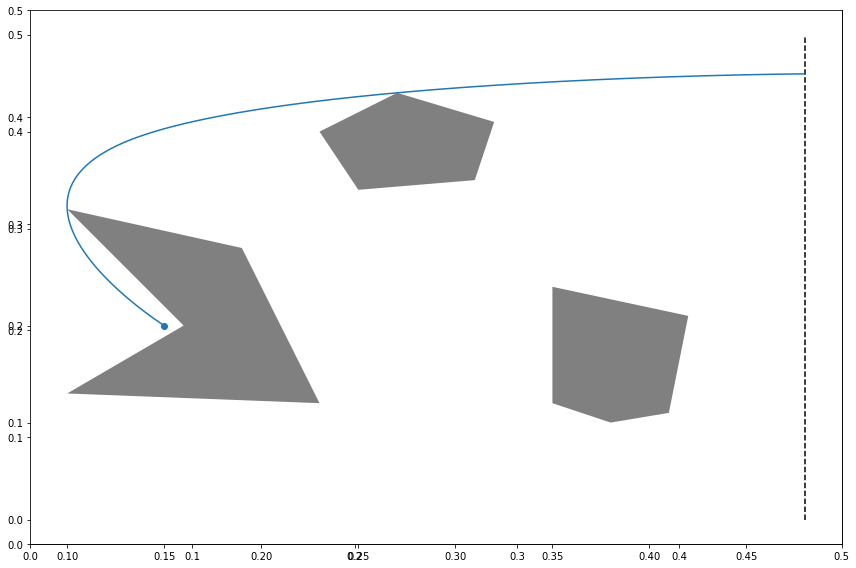

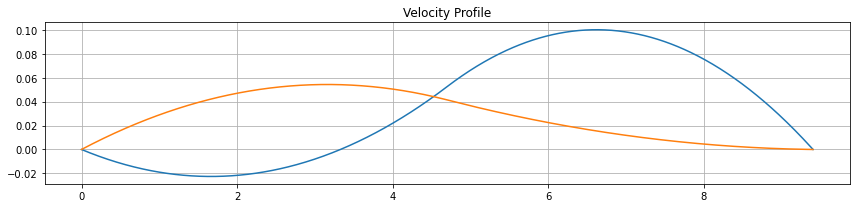

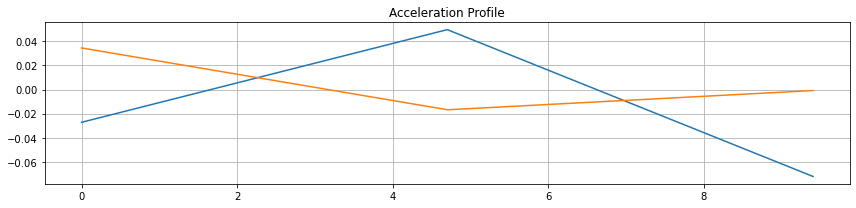

In [10]:
plt.figure(figsize=(12,8))

plt.xlim([q_min[0], q_max[0]])
plt.ylim([q_min[1], q_max[1]])
ax = plt.axes()

plt.scatter(q0[0],q0[1])
plt.plot([xd, xd], [0.0, 0.5], 'k--')
for pol in env.poly_list:
    ax.add_patch(patches.Polygon(pol, facecolor = 'gray'))

plt.plot(pos[:,0], pos[:,1])
plt.tight_layout()

plt.figure(figsize=(12, 3))
plt.grid()
plt.title('Velocity Profile')
plt.plot(t_traj, vel)
plt.tight_layout()

plt.figure(figsize=(12, 3))
plt.grid()
plt.title('Acceleration Profile')
plt.plot(t_traj, acc)
plt.tight_layout()